# Lista 2


Preparando conjunto de treino e test:

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

In [2]:
fields = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']

In [3]:
def processDataset(df):    
    
    # Insere os valores faltando em Age
    mean_age = df['Age'].mean()
    std_age = df['Age'].std() # desvio padrão
    min_value = mean_age - std_age
    max_value = mean_age + std_age

    size = df['Age'].isnull().sum()

    df.loc[df['Age'].isnull(), 'Age'] = np.random.randint(min_value, max_value, size=size)

    df['Age'] = df['Age'].astype(int)   
    
    # Normaliza a idade
    df['Age'] = (df['Age'] - mean_age) / std_age       
    
    # Insere os valores faltando em Embarked
    embarked_values = ['C', 'Q', 'S']
    size = df['Embarked'].isnull().sum()
    random_values = [embarked_values[i] for i in np.random.randint(0, 3, size=size)]
    df.loc[df['Embarked'].isnull(), 'Embarked'] = random_values
    
    df['Embarked'] = df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
    
    #df['Sex'] = df['Sex'].map({'male': 0, 'famale': 1})
    new_sex = []
    for index, row in df.iterrows():
        if row['Sex'] == 'male':
            new_sex.append(0)
        else:
            new_sex.append(1)

    df['Sex'] = new_sex
    
    # Faz o one hot encode em Sex, Embaked, SibSp e Parch, Pclass
    # o  parâmetro'categories' garante que mesmo que o dado esteja faltando será considerado
    sex = df['Sex'].astype(CategoricalDtype(categories=[0, 1]))
    embarked = df['Embarked'].astype(CategoricalDtype(categories=[0, 1, 2]))
    parch = df['Parch'].astype(CategoricalDtype(categories=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
    sibsp = df['SibSp'].astype(CategoricalDtype(categories=[0, 1, 2, 3, 4, 5, 6, 7, 8]))
    pclass = df['Pclass'].astype(CategoricalDtype(categories=[1, 2, 3]))
    
    res = pd.concat([df,pd.get_dummies(sex, prefix='Sex')], axis=1)
    res = pd.concat([res,pd.get_dummies(parch, prefix='Parch')], axis=1)
    #res = pd.concat([res,pd.get_dummies(sibsp, prefix='SibSp')], axis=1)
    res = pd.concat([res,pd.get_dummies(embarked, prefix='Embarked')], axis=1)
    res = pd.concat([res,pd.get_dummies(pclass, prefix='Pclass')], axis=1)
    
    return res

def clearColumns(df, cols):
    df.drop(cols, inplace=True, axis='columns')
    return df

def addSurvivedCol(df_test, df_full):
    survived = []
    
    names = df_test['Name']
    
    for name in names:
        line = df_full.loc[df_full['Name'] == name]
        survived.append(line['Survived'])
    
    df_test['Survived'] = survived
    
    return df_test

def correlation(df, fields, objective):
    correlation_list = {}
    for col in fields:
        correl = np.corrcoef(df[col], df[objective])
        correlation_list[col] = correl[0][1]

    correlation_list = sorted(correlation_list.items(), key=lambda x:x[1], reverse=True)
    for i in range(len(correlation_list)):
        print(str(correlation_list[i][0]) + ': ' + str(correlation_list[i][1]))

def one_hot_encode(x):
    one_hot = np.zeros([len(x), 2])
    for i in enumerate(x):
        one_hot[(i[0], i[1])] = 1
    return one_hot

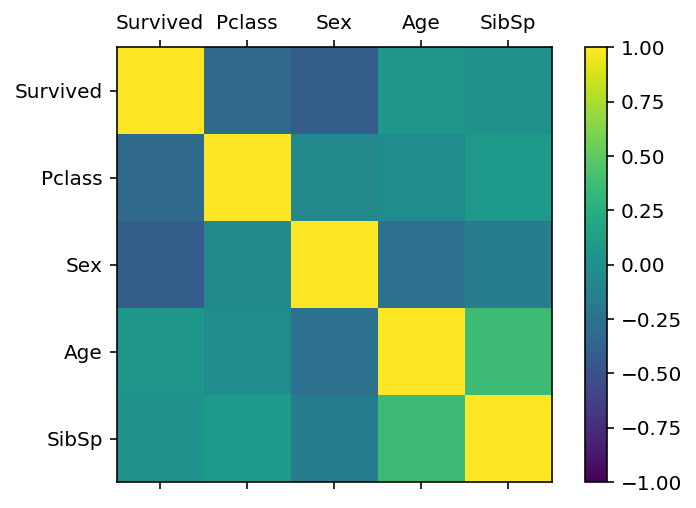

,Pclass,Survived,Sex,Age,SibSp,Parch,Embarked,Sex_0,Sex_1,Parch_0,...,Parch_6,Parch_7,Parch_8,Parch_9,Embarked_0,Embarked_1,Embarked_2,Pclass_1,Pclass_2,Pclass_3
0,1,1,1,-0.061133,0,0,2,0,1,1,...,0,0,0,0,0,0,1,1,0,0


In [4]:
df_full = pd.read_csv('titanic.csv', usecols=fields)
correlations = df_full.corr()

# plot correlação
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,5,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(fields)
ax.set_yticklabels(fields)
plt.show()

df_full = processDataset(df_full)
df_full.head(1)

In [5]:
correlation(df_full, fields, 'Survived')

Survived: 1.0
Sex: 0.5286930913889885
Parch: 0.08265957038609868
SibSp: -0.02782511923058212
Age: -0.03563724686763845
Embarked: -0.1753131114395408
Pclass: -0.3124693626496761


In [6]:
df_full = clearColumns(df_full, ['Sex', 'Embarked', 'Pclass', 'Parch', 'SibSp'])
df_full.head(1)

,Survived,Age,Sex_0,Sex_1,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_7,Parch_8,Parch_9,Embarked_0,Embarked_1,Embarked_2,Pclass_1,Pclass_2,Pclass_3
0,1,-0.061133,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [7]:
# Separa os dados
data_X = df_full.drop(['Survived'], inplace=False, axis='columns').values.tolist()
data_y = df_full['Survived'].values.tolist()

data_X, data_y = shuffle(data_X, data_y, random_state=0)
data_X = np.array(data_X)
data_y = np.array(data_y)
data_y = np.reshape(data_y, (len(data_y), 1))

train_size = 800
val_size = 200

train_X, val_X = data_X[:train_size], data_X[train_size:]
train_y, val_y = data_y[:train_size], data_y[train_size:]

val_X, test_X = val_X[:val_size], val_X[val_size:]
val_y, test_y = val_y[:val_size], val_y[val_size:]

### Rede Neural

In [8]:
RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)

tf.reset_default_graph()

learning_rate = 0.01
epoch = 50
interval = 100
batch_size = 10
n_batches = train_X.shape[0]//batch_size

# Layer's sizes
x_size = train_X.shape[1]   # Number of input nodes: 3 features and 1 bias
h_size = 30                 # Number of hidden nodes
y_size = train_y.shape[1]   # Number of outcomes (8 classes)

# Symbols
X = tf.placeholder(tf.float32, shape=[None, x_size])
y = tf.placeholder(tf.float32, shape=[None, y_size])
keep_prob = tf.placeholder(tf.float32)

# Weight initializations
w1 = tf.Variable(tf.random_normal(shape=(x_size, h_size)))
b1 = tf.Variable(tf.random_normal(shape=[h_size]))
w2 = tf.Variable(tf.random_normal(shape=(h_size, y_size)))
b2 = tf.Variable(tf.random_normal(shape=[y_size]))

# Operations
hidden_output = tf.nn.sigmoid(tf.add(tf.matmul(X, w1), b1))
dropout = tf.nn.dropout(hidden_output, keep_prob)
#final_output = tf.nn.softmax(tf.add(tf.matmul(dropout, w2), b2), name='final_output')
final_output = tf.nn.sigmoid(tf.add(tf.matmul(dropout, w2), b2), name='final_output')

# Cost Function
#loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(final_output), axis=0))
loss = tf.losses.log_loss(y,final_output)

# Optimizer
optimizer = tf.train.AdamOptimizer().minimize(loss)

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Run SGD
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

# Training
print('Training the model...')
losses = {'train':[], 'validation':[]}

for e in range(epoch):
    idxs = np.random.permutation(train_X.shape[0]) #shuffled ordering
    random_X = train_X[idxs]
    random_y = train_y[idxs]
    for i in range(n_batches):
        batch_X = random_X[i * batch_size:(i+1) * batch_size]
        batch_y = random_y[i * batch_size:(i+1) * batch_size]
        sess.run(optimizer,feed_dict = {X: batch_X, y:batch_y, keep_prob:0.8})
        
        if i % interval == 0:
            train_loss = sess.run(loss, feed_dict={X: train_X, y: train_y, keep_prob:1})
            val_loss   = sess.run(loss, feed_dict={X: val_X, y: val_y, keep_prob:1})
            print('Epoch', e, '|',
                  'Batch', i, '|',
                  'Train Loss:', train_loss , '|',
                  'Validation Loss:', val_loss)
            losses['train'].append(train_loss)
            losses['validation'].append(val_loss)

#save_path = saver.save(sess, './model/my_test_model',global_step=1000)
#print("Model saved in path: %s" % save_path)
#sess.close()

Training the model...
Epoch 0 | Batch 0 | Train Loss: 0.82236147 | Validation Loss: 0.8749964
Epoch 1 | Batch 0 | Train Loss: 0.7281142 | Validation Loss: 0.7763933
Epoch 2 | Batch 0 | Train Loss: 0.65583616 | Validation Loss: 0.69644713
Epoch 3 | Batch 0 | Train Loss: 0.610635 | Validation Loss: 0.6483835
Epoch 4 | Batch 0 | Train Loss: 0.57184184 | Validation Loss: 0.6047391
Epoch 5 | Batch 0 | Train Loss: 0.5444349 | Validation Loss: 0.57346463
Epoch 6 | Batch 0 | Train Loss: 0.5223282 | Validation Loss: 0.5491761
Epoch 7 | Batch 0 | Train Loss: 0.5067392 | Validation Loss: 0.5326483
Epoch 8 | Batch 0 | Train Loss: 0.49545032 | Validation Loss: 0.5211594
Epoch 9 | Batch 0 | Train Loss: 0.48452055 | Validation Loss: 0.50974816
Epoch 10 | Batch 0 | Train Loss: 0.4777434 | Validation Loss: 0.5038618
Epoch 11 | Batch 0 | Train Loss: 0.47320136 | Validation Loss: 0.4999781
Epoch 12 | Batch 0 | Train Loss: 0.4683283 | Validation Loss: 0.4959794
Epoch 13 | Batch 0 | Train Loss: 0.46459606 

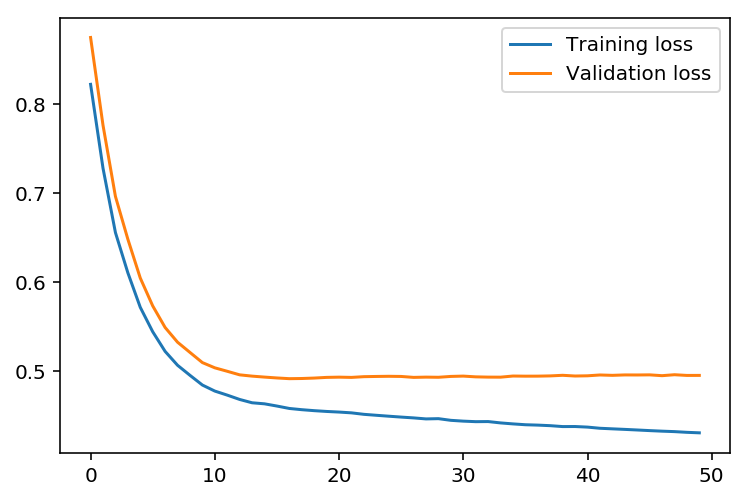

In [9]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

In [10]:
threshold = 0.5
success = 0
results = {'actual':[], 'predicted':[]}
for i in range(len(test_X)):
    predicted = sess.run(final_output, feed_dict={X: [test_X[i]], keep_prob:1})
    results['actual'].append(test_y[i])
    if (test_y[i][0] > threshold and predicted[0][0] > threshold) or (test_y[i][0] < threshold and predicted[0][0] < threshold):
        success += 1
        results['predicted'].append(test_y[i][0])
    else:
        results['predicted'].append(not test_y[i][0])
    #print('Actual:', test_y[i][0], 'Predicted:', predicted[0][0])
    #print('actual:',test_y[i],' | predicted:', predicted)
    #print(predicted[0][0])

print('Accuracy:', success/len(test_X))
print('Confusion Matrix:')
print(confusion_matrix(results['actual'], results['predicted']))
    

Accuracy: 0.8187702265372169
Confusion Matrix:
[[164  18]
 [ 38  89]]
